<a href="https://colab.research.google.com/github/BingHungLee/EDC_Cracking_Furnace_Design/blob/main/%5B20210712%5D_EDC_FireHeater_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP1.EDC Cracking Deriviations Data Preprocessing

In [26]:
import os 
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [17]:
# Method1: Upload CSV From a local drive
'''
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))
dataset= pd.read_csv(filename)
'''

'\nfrom google.colab import files\nuploaded = files.upload()\nfilename = next(iter(uploaded))\ndataset= pd.read_csv(filename)\n'

In [18]:
# Method2: Clone Dataset from github
!git clone https://github.com/BingHungLee/Dataset.git

Cloning into 'Dataset'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [19]:
cd /content/Dataset

/content/Dataset


In [20]:
dataset= pd.read_csv("TECHN.csv")
dataset.head(19)

,temp,p,no,0ppm,200ppm,400ppm,600ppm,800ppm,1000ppm,1200ppm,1400ppm,1600ppm,2000 ppm,2500 ppm
0,324.7,11.40,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,350.0,11.36,1,0.521164,0.522199,0.522365,0.522339,0.522780,0.523014,0.523264,0.523629,0.523948,0.524265,0.524512
2,374.7,11.32,2,1.264740,1.266985,1.270039,1.271721,1.273495,1.274979,1.276487,1.278065,1.279184,1.281570,1.284193
3,399.3,11.27,3,2.323532,2.338824,2.350183,2.359753,2.368227,2.375934,2.383101,2.390065,2.396244,2.407976,2.421589
4,424.0,11.22,4,3.913078,3.971833,4.020674,4.063351,4.101876,4.137400,4.170501,4.201660,4.231296,4.286329,4.349787
5,451.3,11.17,5,7.038567,7.300785,7.531622,7.741569,7.936005,8.118424,8.291328,8.456067,8.614056,8.913114,9.261672
6,460.7,11.11,6,10.306786,10.808612,11.256860,11.666493,12.046700,12.402982,12.739285,13.058335,13.362346,13.931772,14.583877
7,466.0,11.05,7,13.932304,14.660144,15.305010,15.888112,16.421865,16.915613,17.375776,17.807217,18.213583,18.963068,19.803576
8,471.3,11.00,8,18.642807,19.560110,20.359735,21.072657,21.717087,22.307127,22.851570,23.358025,23.831696,24.698040,25.659225
9,476.7,10.94,9,24.359924,25.360992,26.231483,27.005661,27.704718,28.343033,28.931835,29.478745,29.989864,30.923542,31.958382


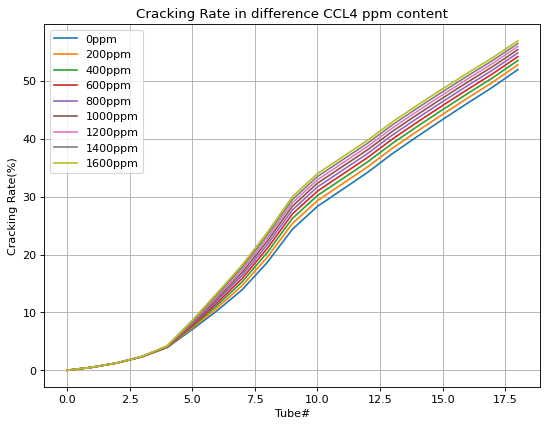

<Figure size 432x288 with 0 Axes>

In [21]:
figure(figsize=(8, 6), dpi=80)

plt.plot(dataset[["no"]],dataset[["0ppm"]],label='0ppm')
plt.plot(dataset[["no"]],dataset[["200ppm"]],label='200ppm')
plt.plot(dataset[["no"]],dataset[["400ppm"]],label='400ppm')
plt.plot(dataset[["no"]],dataset[["600ppm"]],label='600ppm')
plt.plot(dataset[["no"]],dataset[["800ppm"]],label='800ppm')
plt.plot(dataset[["no"]],dataset[["1000ppm"]],label='1000ppm')
plt.plot(dataset[["no"]],dataset[["1200ppm"]],label='1200ppm')
plt.plot(dataset[["no"]],dataset[["1400ppm"]],label='1400ppm')
plt.plot(dataset[["no"]],dataset[["1600ppm"]],label='1600ppm')

plt.title("Cracking Rate in difference CCL4 ppm content",) 
plt.ylabel("Cracking Rate(%)",) 
plt.xlabel("Tube#",)
plt.legend()
plt.grid(True)
plt.show()

plt.savefig("CR.png")

## ➜ Data Preprocessing: Arrhenius Equation Parameters A and Ea (Chemical Deriviation)

In [23]:
cases_queue = dataset.columns[3:len(dataset.columns)]
cases_queue.size

11

In [28]:
def CtoK(temp):
  return temp+273.15
def PkgGtoatm(pressure):
  return (pressure +1)*0.967841
dataset[["temp"]] = CtoK(dataset[["temp"]]) # Transform temp from celsius to kelvin
dataset[["p"]] = PkgGtoatm(dataset[["p"]]) # Transform pressure from kg/cm2G to atm

In [29]:
def EDC_crack_derive(ppm):
  case = dataset[["no","temp","p",ppm]]
  row_count = case.shape[0] # Gives number of rows
  ppm = case.columns[3]

  #Reactor Parameters
  D = 0.2027        # tube inside diameter 0.2027 (m)
  L = 18          # tube length 18 (m)
  NTube = 18        # Number of tubes
  mdot_in_kg = 36000    # In-tube flow rate (kg/hr)
  mdot_in_mole = 363.7864  # In-tube flow rate (kmole/hr)

  HTA = 0.25*math.pi*0.2027**2*18*18 # Total heat transfer area for whole reactor
  HTAperTuber = HTA/18        # heat transfer area per tube

  #Derived Parameters
  EDC = mdot_in_mole* (1-case[ppm]/100)          #kmole/hr
  VCM = mdot_in_mole - mdot_in_mole* (1-case[ppm]/100) #kmole/hr
  HCL = VCM                        #kmole/hr
  Total_mole = EDC+VCM+HCL                 #kmole/hr

  R = 8205E-5 # idael gas constant m3.atm.K^-1.mol^-1

  # Caclulate Volume Flow per Tube (m3/hr)
  VTube = Total_mole*R*case["temp"]/case["p"]

  # Calculate Residence time per tube (s)
  Rtime = HTAperTuber/VTube*3600

  ln=[]
  for i in range(row_count-1):
    tmp = np.log(EDC[i+1]/EDC[i])
    #print(tmp)
    ln = np.append(ln,tmp)  

  Rt=[]
  for i in range(row_count-1):
    tmp = (Rtime[i]+Rtime[i+1])/2
    #print(tmp)
    Rt = np.append(Rt,tmp)  

  # Calculate reaction rate k per tube
  k = ln/Rt
  ln_k = np.log(-k)

  Tr = 1/case["temp"]

  Tr_=[]
  for i in range(row_count-1):
    tmp = (Tr[i]+Tr[i+1])/2
    #print(tmp)
    Tr_ = np.append(Tr_,tmp)  

  # Linear regression
  from sklearn import linear_model
  from sklearn.metrics import r2_score
  reg_model = linear_model.LinearRegression()
  Tr_ = Tr_.reshape(-1,1)
  reg_model.fit(Tr_,ln_k)

  print("----------------------------------------------------------")
  print("CASE :", ppm)
  rmse=np.sqrt(np.mean((reg_model.predict(Tr_)-ln_k)**2))
  print("model rmse :", rmse)
  r2_=r2_score(ln_k,reg_model.predict(Tr_))
  print("model R2 score :",r2_score(ln_k,reg_model.predict(Tr_)))
  A = math.exp(reg_model.intercept_)
  Ea = -reg_model.coef_*1.987
  
  #print("ln(A) :",reg_model.intercept_)
  print("A :" ,math.exp(reg_model.intercept_))
  #print("Ea/R :",-reg_model.coef_)
  print("Ea :",-reg_model.coef_*1.987)

  plt.scatter(Tr_,ln_k)
  plt.plot(Tr_,reg_model.predict(Tr_))
  plt.xlabel("1/T")
  plt.ylabel("ln(k)")
  plt.title(ppm)
  plt.show()

  return A,Ea,r2_,rmse

----------------------------------------------------------
CASE : 0ppm
model rmse : 0.16095572401306044
model R2 score : 0.9709621312891251
A : 30851.393222392773
Ea : [19564.06604899]


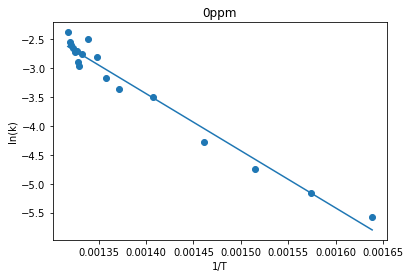

----------------------------------------------------------
CASE : 200ppm
model rmse : 0.1572252123531531
model R2 score : 0.9725632014302044
A : 34289.652559358205
Ea : [19676.52067031]


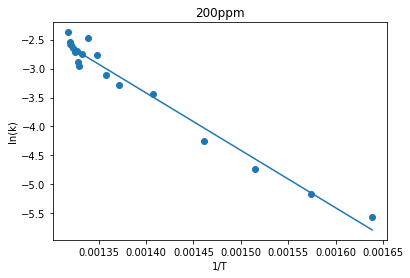

----------------------------------------------------------
CASE : 400ppm
model rmse : 0.15646691177052202
model R2 score : 0.9731125584180242
A : 37907.40482520598
Ea : [19786.23790235]


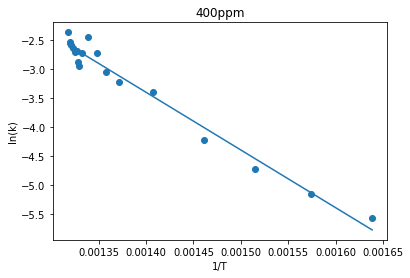

----------------------------------------------------------
CASE : 600ppm
model rmse : 0.15739569728006012
model R2 score : 0.9730824315494027
A : 41690.05538739209
Ea : [19892.23932479]


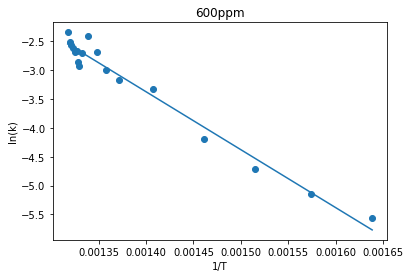

----------------------------------------------------------
CASE : 800ppm
model rmse : 0.1594394481496427
model R2 score : 0.972660221882584
A : 45497.14899388591
Ea : [19989.99954658]


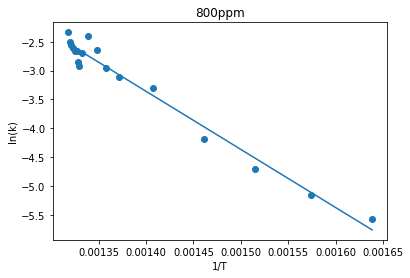

----------------------------------------------------------
CASE : 1000ppm
model rmse : 0.16205918131025376
model R2 score : 0.97203192261918
A : 49387.183769013616
Ea : [20082.44171631]


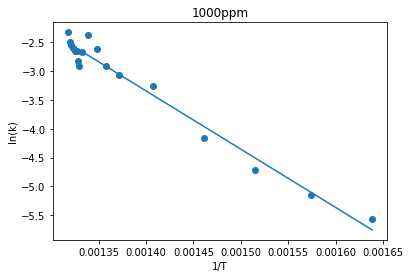

----------------------------------------------------------
CASE : 1200ppm
model rmse : 0.16503452159106113
model R2 score : 0.9712666487000652
A : 53319.39070922931
Ea : [20169.02072691]


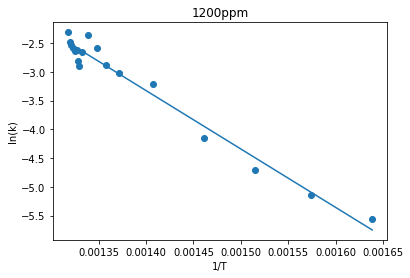

----------------------------------------------------------
CASE : 1400ppm
model rmse : 0.168205167070031
model R2 score : 0.9704150776174674
A : 57259.941386324856
Ea : [20249.61639153]


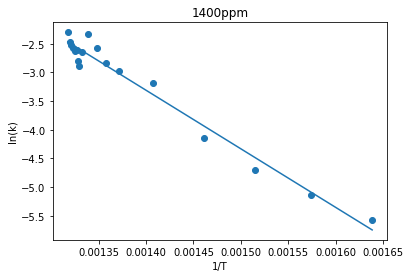

----------------------------------------------------------
CASE : 1600ppm
model rmse : 0.17146292504292987
model R2 score : 0.969519393814037
A : 61287.81846050362
Ea : [20326.87402801]


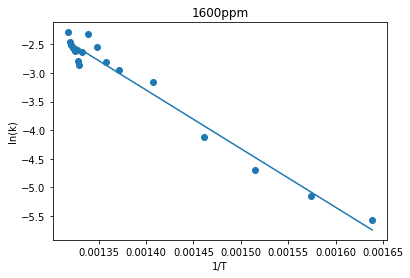

----------------------------------------------------------
CASE : 2000 ppm
model rmse : 0.17796842105850993
model R2 score : 0.9676799370584501
A : 69460.36789953303
Ea : [20469.47169112]


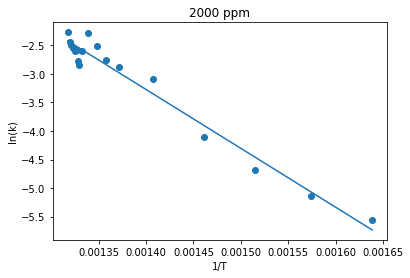

----------------------------------------------------------
CASE : 2500 ppm
model rmse : 0.18579676413129587
model R2 score : 0.9653983965272758
A : 79874.1520415609
Ea : [20628.95540584]


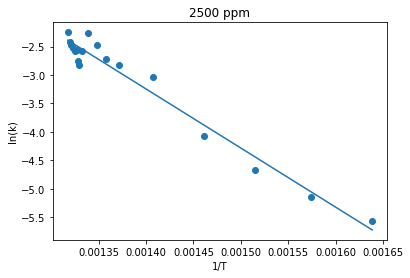

In [30]:
A=[]
Ea=[]
r2=[]
rmse=[]

for i in range(cases_queue.size):
  Atmp, Eatmp,r2tmp, rmsetmp = EDC_crack_derive(cases_queue[i])
  A = np.append(A,Atmp)
  Ea = np.append(Ea,Eatmp)
  r2 = np.append(r2,r2tmp)
  rmse = np.append(rmse,rmsetmp)

In [31]:
df = pd.DataFrame({"ppm":cases_queue,'A':A,'Ea':Ea,"r2":r2,"rmse":rmse})
df

,ppm,A,Ea,r2,rmse
0,0ppm,30851.393222,19564.066049,0.970962,0.160956
1,200ppm,34289.652559,19676.520670,0.972563,0.157225
2,400ppm,37907.404825,19786.237902,0.973113,0.156467
3,600ppm,41690.055387,19892.239325,0.973082,0.157396
4,800ppm,45497.148994,19989.999547,0.972660,0.159439
5,1000ppm,49387.183769,20082.441716,0.972032,0.162059
6,1200ppm,53319.390709,20169.020727,0.971267,0.165035
7,1400ppm,57259.941386,20249.616392,0.970415,0.168205
8,1600ppm,61287.818461,20326.874028,0.969519,0.171463
9,2000 ppm,69460.367900,20469.471691,0.967680,0.177968
